**This notebook explores how to code time series with real data, with SARIMA model**

## SARIMA (Seasonal AutoRegressive Integrated Moving Average)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

#### The CATFISH SALES 
The data is for several years, but I focussd here on the sales in between Jan-1986 to Jan-2004.

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
df = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
df.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Name: Total, dtype: int64

In [5]:
df = df.asfreq(pd.infer_freq(df.index))

In [6]:
df.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Freq: MS, Name: Total, dtype: int64

In [7]:
df.tail()

Date
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, dtype: int64

In [8]:
start_date = datetime(1986,1,1)
end_date = datetime(2004,1,1)
lim_df= df[start_date:end_date]

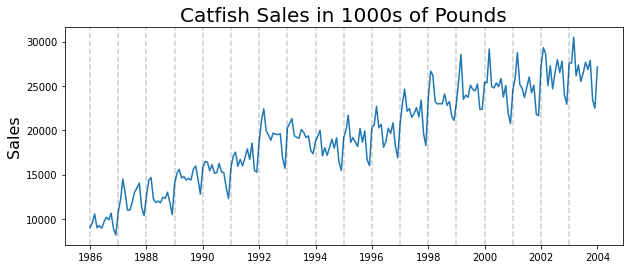

In [9]:
plt.figure(figsize=(10,4))
plt.plot(lim_df)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

**A couple of things are clearly noticed in the monthly chart above between Sales(in thousands) and Year.
First Within each year there are twelve observations, one for each month. Then there is defineitly an upwards trend. Also there is seasonality in the series, because sales is down at he end of year and jumps up every year beginning.This pattern is presetn through the course of year.**

**These things are evidence of NON-STATIONARITY in the series. Although its visulaly clear, but for a robust confirmation of non stationarity in the series, Dicky Fuller test could be done.** 

**In order to transform the series into stationary one(which is a prerequiste for SARIMA model), Trend and Seasonality needs to be removed.**

## Remove The Trend (By Differncing method)

In [10]:
first_diff = lim_df.diff()[1:]

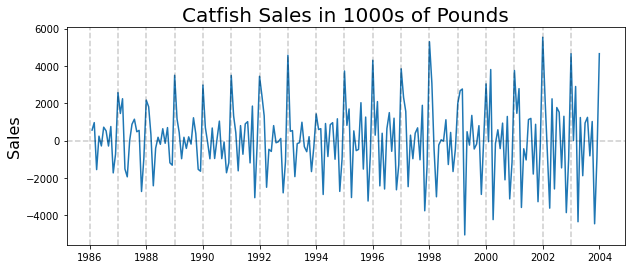

In [11]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

**Just by taking the fist difference, the series is now centered around 0, so there's no upwards/downwards trend. So we can use a integrated order of 1.
But still there is seasonality of course.**

**Next, to get an idea of what order to use for the seasonal AR and seasonal MA parts, ACF and PACF are used as below:**

### ACF

c:\users\soumya ranjan\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
c:\users\soumya ranjan\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 40 artists>

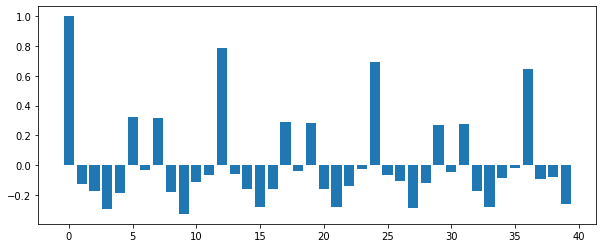

In [12]:
acf_vals = acf(first_diff)
num_lags = 40
plt.figure(figsize=(10,4))
plt.bar(range(num_lags), acf_vals[:num_lags])

**Based on ACF,it's seen that at there's a significant lag at every 12th one. Hence a seasonal MA process with lag of 12months or 1 year is needed**

### PACF

c:\users\soumya ranjan\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1022: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<BarContainer object of 15 artists>

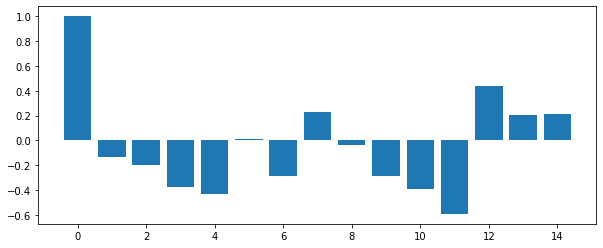

In [13]:
plt.figure(figsize=(10,4))
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

**Similarly based on PACF, we should start with a seasonal AR process of lag 12months or 1 year.**

**Getting the train and test sets:**

In [14]:
train_end = datetime(1999,1,1)
test_end = datetime(2004,1,1)

train_data = lim_df[:train_end]
test_data = lim_df[train_end + timedelta(days=1):test_end]

### Fiting the SARIMA Model

**There's two different sets of orders needed to be fit.First there's going to be the order for regualr AR, I and MA parts; Then the order for the seasonal AR,I and MA parts. Based on above analysis:**
* Order for regular AR, I and MA : (0,1,0)
* Order for seasonal AR, I and MA models: (1,0,1,12)

In [15]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [16]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.28255128860473633


In [17]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1273.317
Date:                              Wed, 02 Dec 2020   AIC                           2552.635
Time:                                      11:48:31   BIC                           2561.784
Sample:                                  01-01-1986   HQIC                          2556.351
                                       - 01-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9924      0.009    110.454      0.000       0.975       1.010
ma.S.L12      -0.83

In [18]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

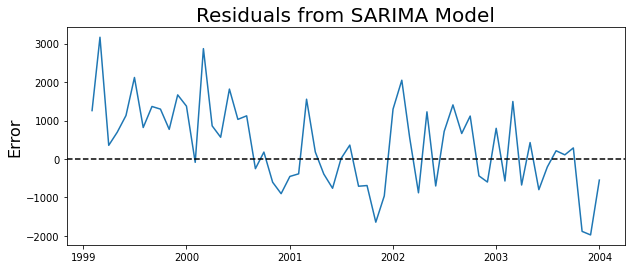

In [19]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

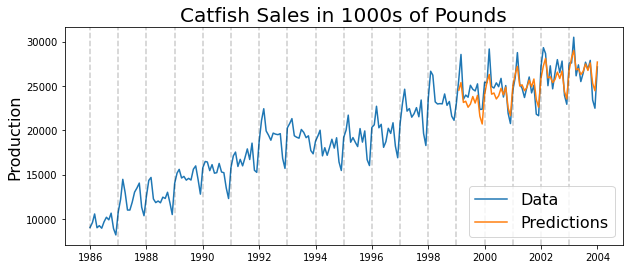

In [20]:
plt.figure(figsize=(10,4))

plt.plot(lim_df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [21]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0367
Root Mean Squared Error: 1140.3520962886255
